In [32]:
import json
import sys
from requests import Session, Request
from datetime import datetime, date, time, timedelta, timezone
from posixpath import join as urljoin
import pandas as pd
import io
from blume import client, station, measurements
from blume.station import Station
from sensemapi import client as sense_client
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

import logging
logging.getLogger().setLevel(logging.CRITICAL)

from sklearn import preprocessing, svm 
from sklearn.model_selection import train_test_split, validation_curve, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import sklearn.metrics
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.feature_selection import SelectFromModel
import pytz
cet, utc = pytz.timezone('CET'), pytz.timezone('UTC')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# set the graphs to show in the jupyter notebook
%matplotlib inline
graph_dir = "ressources/grapics/"

# set seaborn style to white
sns.set_style("white")

In [12]:
logging.getLogger().setLevel(logging.INFO)

# Load Datasets
First load the OSeM-Datasets from previous notebooks and print out some initial information about it.

In [13]:
try:
    df_osem_mins = pd.read_csv("ressources/PM10_Measurments_Berlin_Minutes.cvs", index_col=0, parse_dates=True)#Make global index timezone (Berlin) aware for comparison
    #Manually Converting the Timezone AGAIN, because BLUME Data is like this
    df_osem_mins.index = df_osem_mins.index.tz_convert(cet)
    df_osem_mins = df_osem_mins.loc[~df_osem_mins.index.duplicated(keep='first')]
    df_osem_mins.sort_index(inplace=True)

except:
    df_osem_mins = pd.DataFrame()
    
try:
    df_osem_hours = pd.read_csv("ressources/PM10_Measurments_Berlin_Hours.cvs", index_col=0, parse_dates=True)
    #Manually Converting the Timezone AGAIN, because BLUME Data is like this
    df_osem_hours.index = df_osem_hours.index.tz_convert(cet)
    df_osem_hours = df_osem_hours.loc[~df_osem_hours.index.duplicated(keep='first')]
    df_osem_hours.sort_index(inplace=True)

except:
    df_osem_hours = pd.DataFrame()

## External Verification

Inside this Section we try to verifiy the Data we are working with. There have been multiple occasions where we already got prove, that we are working with accurate data, but in the next section we try to showcase some graphical verification. We take one of our sensors and download the daily graph provided from OSeM Website. Then we try to rebuild this exact graph with the data from our database.

First we build our graph:

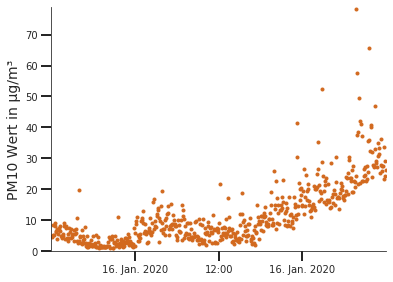

In [14]:
lookup = "59f8af62356823000fcc460c"
lookup_column = ""        
for column in df_osem_mins.columns:
    if column[:22] == lookup[:22]:
        lookup_column = column

s1 = pd.Timestamp(2020, 1, 16, 0,0,0)
s1 = pd.Timestamp(s1, tz="UTC")
s2 = pd.Timestamp(2020, 1, 16, 23,59,59)
s2 = pd.Timestamp(s2, tz="UTC")
        
osem_plot_data = df_osem_mins[lookup_column][s1:s2].dropna()

x = date2num(osem_plot_data.index)

axis_timestamps = [pd.Timestamp(2020, 1, 16, 6,0,0), pd.Timestamp(2020, 1, 16, 12,0,0), pd.Timestamp(2020, 1, 16, 18,0,0)]
axis_timestamp_labels = ["16. Jan. 2020", "12:00", "16. Jan. 2020"]

fig, ax1 = plt.subplots(figsize=(6, 4.5))
ax1.scatter(x, osem_plot_data, color="chocolate", marker=".")
ax1.set_xlim(s1, s2)
ax1.set_ylim(0,79)
ax1.set_xticks(axis_timestamps)
ax1.set_xticklabels(axis_timestamp_labels)
ax1.tick_params(axis="both", direction="out", which="both", bottom=True, left=True, width=2, length=10)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax1.set_ylabel('PM10 Wert in µg/m³', fontsize=14)

fig.savefig(graph_dir + "osem_verification_24h.png", transparent=True, bbox_inches="tight",pad_inches=0.1, dpi=200)

Now lets see the original graph and compare:

<img src="ressources/grapics/osem_website_verification_24h.png" alt="drawing" align="left"/>

In [20]:
df_osem_hours

,590b8480dd09cc0011aa79cd_PM10,591ecdc251d3460011651ffa_PM10,592ca4b851d3460011ea2636_PM10,593458ddad0fa30011ea0962_PM10,5936c52aad0fa30011033d68_PM10,594c01c7be77820011792181_PM10,595178fb94f0520011e083ed_PM10,5984c712e3b1fa001069150d_PM10,5998a7bad67eb500114b7d7b_PM10,599f3364d67eb50011b85cd4_PM10,...,5e02b67d475fc6001a132e36_PM10,5e07550d8c8053001a9fe669_PM10,5e078ec58c8053001ab19512_PM10,5e0ba32b7c9a10001ac5ca69_PM10,5e10d5bab0c088001bf1d26d_PM10,5e127d1fe5e60c001a89aba4_PM10,5e14e11ae5e60c001a4e5731_PM10,5e242095b9b1f3001af00bd9_PM10,5e25fe07386af6001a5771b8_PM10,5e2c6ed68ede87001b571458_PM10
2019-11-20 01:00:00+01:00,23.208261,24.645652,3.731667,NaN,12.997500,30.642609,20.181905,36.946667,17.271250,19.793684,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-20 02:00:00+01:00,24.926667,26.518800,3.047917,NaN,7.983333,17.879167,20.019545,35.577500,14.371667,22.781897,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-20 03:00:00+01:00,23.547500,25.232083,2.050417,NaN,6.065833,6.963750,21.961364,31.237200,14.317200,24.693509,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-20 04:00:00+01:00,19.546522,24.045200,1.536250,NaN,6.910833,6.439130,19.994286,31.590417,15.174091,20.171429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-20 05:00:00+01:00,22.477391,25.015217,1.385200,NaN,6.658333,9.937391,19.770952,40.023333,16.366522,23.911091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-27 20:00:00+01:00,NaN,NaN,12.922500,6.083333,10.656667,NaN,14.086000,21.285000,15.009200,19.727544,...,15.930351,16.647500,13.808667,13.250435,NaN,18.614545,13.796250,12.869583,0.209583,13.712500
2020-01-27 21:00:00+01:00,NaN,NaN,11.393600,6.768750,12.622500,NaN,13.567917,21.703200,16.188750,14.903860,...,18.291818,16.678333,14.802000,13.619167,NaN,16.733000,13.641250,14.064583,0.200000,13.979167
2020-01-27 22:00:00+01:00,NaN,NaN,7.466250,6.599600,14.525000,NaN,17.967391,22.401667,17.827500,21.996964,...,27.245714,14.130000,16.575333,17.757083,NaN,18.964000,14.877500,16.697500,0.200000,14.682917
2020-01-27 23:00:00+01:00,NaN,NaN,5.604167,9.232917,15.205000,NaN,21.655417,29.700833,22.451200,29.595088,...,29.739286,18.269167,17.480000,22.538750,NaN,22.450714,21.837917,19.213600,0.195833,17.269583


In [21]:
df_osem_hours.mean(axis=1)

2019-11-20 01:00:00+01:00    15.146148
2019-11-20 02:00:00+01:00    14.671363
2019-11-20 03:00:00+01:00    14.258506
2019-11-20 04:00:00+01:00    14.239528
2019-11-20 05:00:00+01:00    16.234857
                               ...    
2020-01-27 20:00:00+01:00    12.345081
2020-01-27 21:00:00+01:00    15.640703
2020-01-27 22:00:00+01:00    15.129985
2020-01-27 23:00:00+01:00    17.308251
2020-01-28 00:00:00+01:00    21.520021
Length: 1656, dtype: float64

Auszug aus dem Datensatz:

In [22]:
df_osem_mins.head()

,590b8480dd09cc0011aa79cd_PM10,591ecdc251d3460011651ffa_PM10,592ca4b851d3460011ea2636_PM10,593458ddad0fa30011ea0962_PM10,5936c52aad0fa30011033d68_PM10,594c01c7be77820011792181_PM10,595178fb94f0520011e083ed_PM10,5984c712e3b1fa001069150d_PM10,5998a7bad67eb500114b7d7b_PM10,599f3364d67eb50011b85cd4_PM10,...,5e02b67d475fc6001a132e36_PM10,5e07550d8c8053001a9fe669_PM10,5e078ec58c8053001ab19512_PM10,5e0ba32b7c9a10001ac5ca69_PM10,5e10d5bab0c088001bf1d26d_PM10,5e127d1fe5e60c001a89aba4_PM10,5e14e11ae5e60c001a4e5731_PM10,5e242095b9b1f3001af00bd9_PM10,5e25fe07386af6001a5771b8_PM10,5e2c6ed68ede87001b571458_PM10
2019-11-20 00:00:00+01:00,NaN,NaN,3.37,NaN,NaN,NaN,NaN,NaN,NaN,15.80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-20 00:01:00+01:00,20.02,NaN,NaN,NaN,NaN,NaN,NaN,38.2,NaN,17.17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-20 00:02:00+01:00,NaN,19.70,4.70,NaN,NaN,12.60,32.70,NaN,13.33,13.88,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-20 00:03:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-20 00:04:00+01:00,21.67,24.07,NaN,NaN,15.9,19.07,35.35,39.0,15.00,14.85,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Übersicht der Date-Range an Verfügbaren Messwerten (in Minuten):

In [23]:
df_osem_mins.index

DatetimeIndex(['2019-11-20 00:00:00+01:00', '2019-11-20 00:01:00+01:00',
               '2019-11-20 00:02:00+01:00', '2019-11-20 00:03:00+01:00',
               '2019-11-20 00:04:00+01:00', '2019-11-20 00:05:00+01:00',
               '2019-11-20 00:06:00+01:00', '2019-11-20 00:07:00+01:00',
               '2019-11-20 00:08:00+01:00', '2019-11-20 00:09:00+01:00',
               ...
               '2020-01-27 23:50:00+01:00', '2020-01-27 23:51:00+01:00',
               '2020-01-27 23:52:00+01:00', '2020-01-27 23:53:00+01:00',
               '2020-01-27 23:54:00+01:00', '2020-01-27 23:55:00+01:00',
               '2020-01-27 23:56:00+01:00', '2020-01-27 23:57:00+01:00',
               '2020-01-27 23:58:00+01:00', '2020-01-27 23:59:00+01:00'],
              dtype='datetime64[ns, CET]', length=99360, freq=None)

Now load the BLUME-Dataset and refresh with the newest available measurements.

In [24]:
#Scrape newest/available data from the Blume-Website
df_temp = client.get_blume_measurments()
df_temp = client.clean_data(df_temp)

#Create Measurements and append to local storage of data (JSON)
online_measurement = client.create_measurements(df_temp)

#Initially load all Stations from local storage (JSON)
station.init_stations()
#Source all available Information from local storage to pandas df
station_collection = Station.station_collection

#get all available station ids and use them to get all measurements from all
# stations
station_ids = [station.id for station in station_collection]
all_station_measurements = measurements.read_measurements_by_station_id_list(
    station_ids)

#from all measurements, get pandas series and combine to global matrix
df_blume_local = [m.dataframe for m in all_station_measurements]
df_blume_global = pd.concat(df_blume_local, axis=1)

#Make global index timezone (Berlin) aware for comparison
df_blume_global.index = df_blume_global.index.tz_localize(cet)
df_blume_global.to_csv("ressources/blume_global.csv")

Auszug aus dem Datensatz:

In [25]:
df_blume_global.tail()

,10,32,42,77,85,88,117,124,143,171,174,220
2020-03-27 02:00:00+01:00,38,37.0,42.0,39,41.0,49.0,45.0,47.0,NaN,37.0,44.0,43
2020-03-27 03:00:00+01:00,38,39.0,42.0,40,42.0,49.0,46.0,49.0,NaN,37.0,45.0,43
2020-03-27 04:00:00+01:00,41,41.0,44.0,42,43.0,52.0,48.0,50.0,NaN,39.0,46.0,44
2020-03-27 05:00:00+01:00,41,42.0,46.0,42,45.0,55.0,49.0,51.0,NaN,42.0,50.0,46
2020-03-27 06:00:00+01:00,43,42.0,49.0,44,47.0,57.0,53.0,56.0,NaN,44.0,53.0,49


Übersicht der Date-Range an Verfügbaren Messwerten (in Stunden):

# Vergleiche Stundenmittel über Zeitraum
Zunächst werden Helper-Functions definiert, die den Vergleich durchführen sollen.

In [26]:
def compare_osem_blume(blume, osem, start, end, verbose=False):
    """Funktion zum Vergleichen der stündlichen Messwerte von BLUME und OSeM

    Parameters:
        argument1 (int): Description of arg1
        blume (pandas Dataframe): DF mit BLUME Messwerten verschiedener Stationen stündlich gemittelt
        osem (pandas Dataframe): DF mit OSeM Messwerten verschiedener Stationen stündlich gemittelt
        start (datetime.datetime): Startdatum als Datetime Objekt
        end (datetime.datetime): Enddatum als Datetime Objekt
        verbose (boolean): Aktiviere Output

    Returns:
        int:Returning value

    """
    

    #Gruppiere alle Stationen zusammen per Mittelwert (Betrachte Berlin, nicht einzelne Stationen)
    blume_mean = blume.mean(axis=1)
    blume_mean.name="BLUME"
    osem_mean = osem.mean(axis=1)
    osem_mean.name="OSeM"

    #Reduziere Daten auf den gewünschten Datumsbereich
    blume_mean = blume_mean.loc[start:end]
    osem_mean = osem_mean.loc[start:end]
    #Alternative: mask = (blume.index >= start) & (blume.index <= blume_to_date)
    
    #Aktiviere das, wenn man mögliche Fehlende Tage bei einem der DS raushauen will
    intersec = osem_mean.index.intersection(blume_mean.index)
    osem_mean = osem_mean.loc[intersec]
    blume_mean = blume_mean.loc[intersec]   
    
    if(verbose):    
        print("Comparing Datasets starting from {:%d.%m.%Y-%H:%M} until {:%d.%m.%Y-%H:%M}".format(start, end))
        print("Shape: BLUME {} vs. OSeM {}".format(blume_mean.shape, osem_mean.shape))

    if not (blume_mean.index.equals(osem_mean.index)):

        print("Index not completely identical error")
        print("Shape: BLUME {} vs. OSeM {}".format(blume.shape, osem.shape))
        print("Check if all Values are hourly means and start-end date is correct")
        return None
    
    blume_osem_hourly_df = pd.concat([blume_mean, osem_mean], axis=1)
    r2_current = sklearn.metrics.r2_score(y_true=blume_mean, y_pred=osem_mean)
    mae_current = sklearn.metrics.mean_absolute_error(y_true=blume_mean, y_pred=osem_mean)
    mse_current = sklearn.metrics.mean_squared_error(y_true=blume_mean, y_pred=osem_mean)
    
    metrics_current = {"R2":r2_current, "MAE":mae_current, "MSE":mse_current, "BLUMEAVG":blume_mean.mean()}
    
    return blume_osem_hourly_df, metrics_current


### Test 1) Monats-Vergleich für Dezember 2019:

**Vorgang:** Mit den stündlichen PM10-Mittelwerten des Monats Dezember von OSeM und BLUME wurden die Mittelwerte aller Sensoren (OSeM) bzw. Stationen (BLUME) ermittelt. Diese beiden Mittelwerte spiegeln also die Mittelwerte für Gesamt-Berlin ab. Zunächst wurden die Daten in einem Linienplot übereinander gelegt und dann mittels linearer Regression verglichen.

Hinweis: Die Achsen zeigen nur einen Ausschnitt: Zur Feingranulareren Darstellung wurden einzelne Ausreißerpunkte entfernt die den Zoom stören.

Comparing Datasets starting from 01.12.2019-00:00 until 24.01.2020-00:00
Shape: BLUME (1297,) vs. OSeM (1297,)


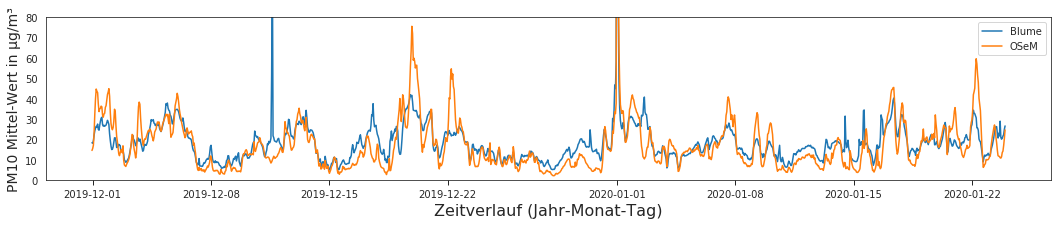

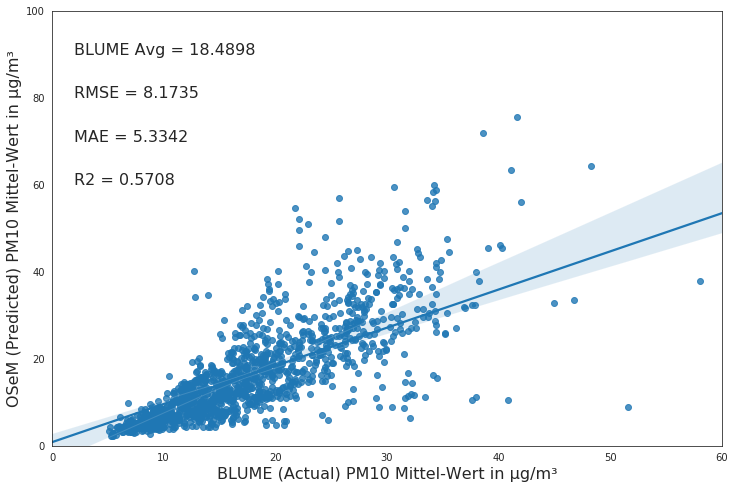

In [27]:
#Calculate everything
example_to_date = pd.Timestamp(2020,1,24)
example_to_date = pd.Timestamp(example_to_date, tz="CET")
example_from_date = pd.Timestamp(2019,12,1)
example_from_date = pd.Timestamp(example_from_date, tz="CET")
#example_from_date = example_to_date - timedelta(days=29)
comp_month, metrics_month = compare_osem_blume(blume=df_blume_global, osem=df_osem_hours, start=example_from_date, end=example_to_date, verbose=True)

#Plot Timeseries
fig, ax1 = plt.subplots(figsize=(18, 3))
ax1.plot(comp_month["BLUME"], label="Blume")
ax1.plot(comp_month["OSeM"], label="OSeM")
ax1.set_xlabel('Zeitverlauf (Jahr-Monat-Tag)', fontsize=16)
ax1.set_ylabel('PM10 Mittel-Wert in µg/m³', fontsize=14)
ax1.tick_params(axis="both", direction="out", which="both", bottom=True, width=1, length=5)
ax1.set_ylim(0, 80)
ax1.legend(loc='best')
#fig.suptitle('Berlinweiter Mittelwertvergleich OSEeM vs. BLUME im Gesamtzeitraum' , fontsize=16)
fig.savefig(graph_dir + "all_time_lineplot.png", transparent=True, bbox_inches="tight",pad_inches=0.1, dpi=200)

#(Sub)Plot Linear Regression
fig, ax1 = plt.subplots(figsize=(12, 8))  #sublot(Anzahl Zeilen Anzahl Spalten Bild Nummer)
sns.regplot(x="BLUME", y="OSeM", data=comp_month, ax=ax1)
#ax1.set_title("Lineare Regression (Actual by Predicted Plot)", fontsize=16)
ax1.set_xlabel('BLUME (Actual) PM10 Mittel-Wert in µg/m³', fontsize=16)
ax1.set_ylabel('OSeM (Predicted) PM10 Mittel-Wert in µg/m³', fontsize=16)
ax1.set_ylim(0,100)
ax1.set_xlim(0,60)
ax1.text(2, 90, fontsize=16, s=('BLUME Avg = {}'.format(round(metrics_month["BLUMEAVG"],4))))
ax1.text(2, 80, fontsize=16, s=('RMSE = {}'.format(round(np.sqrt(metrics_month["MSE"]),4))))
ax1.text(2, 70, fontsize=16, s=('MAE = {}'.format(round(metrics_month["MAE"],4))))
ax1.text(2, 60, fontsize=16, s=('R2 = {}'.format(round(metrics_month["R2"],4))))

fig.savefig(graph_dir + "all_time_regplot.png", transparent=True, bbox_inches="tight",pad_inches=0.1, dpi=200)
plt.show()
#(Sub)Plot 
#TODO

#plt.subplot(122)  #sublot(Anzahl Zeilen Anzahl Spalten Bild Nummer)

**Erkentniss:** 
- Bei der grafischen Betrachtung der Plots lässt sich eine solide Linearität erkennen. Die Daten folgen ungefähr ähnlichen Tendenzen und Ausschlägen. Einzelne Ausreißer auf beiden Seiten sind nicht wirklich erklärbar.
- MAE: Die Betrachtung der Metriken deutet darauf hin, dass insbesondere der MAE-Wert als Vergleichsmittel geignet ist. Die gemittelte Abweichung über den Monat Dezember beträgt 5.5789, d.H. wenn man mit allen Berliner PM10 Sensoren der OSeM versucht, den Berlinweiten PM10-Mittelwert vorherzusagen, dann liegt man im Durchschnitt +/- 5.5789 daneben.
- R2: Der R2 Wert ist im Durschnitt negativ. Das bedeutet, dass mit den Werten der OSeM die veränderungen in den Werten der BLUME nicht erklärt werden können.
- MSE: Der MSE liegt sehr hoch. Er bestraft insbesonders lokale Ausreiser besonders stark. Da die Abweichung aber nicht exponentiell mit der Entfernung schlimmer wird, ist der MSE zum Messen hier weniger geeignet.

### Test 2) Wochen-Vergleich für Woche im Dezember 2019:
**Vorgang:** Es wird ein WochenAuschnitt aus den Daten genommen. Diese werden dann wie schon beim Monatsvergleich übereinandergelegt und die Metriken verglichen. Aufgrund bestimmter Zeitabhänger Einflussfaktoren (z.B. Sonntag = Ruhetag) soll untersucht werden, ob die Ähnlichkeit und Metriken bei einem verkleinerten Zeitraum besser oder schlechter sind.

Hinweis: Die Achsen zeigen nur einen Ausschnitt: Zur Feingranulareren Darstellung wurden einzelne Ausreißerpunkte entfernt die den Zoom stören.

Comparing Datasets starting from 04.12.2019-00:00 until 11.12.2019-00:00
Shape: BLUME (169,) vs. OSeM (169,)


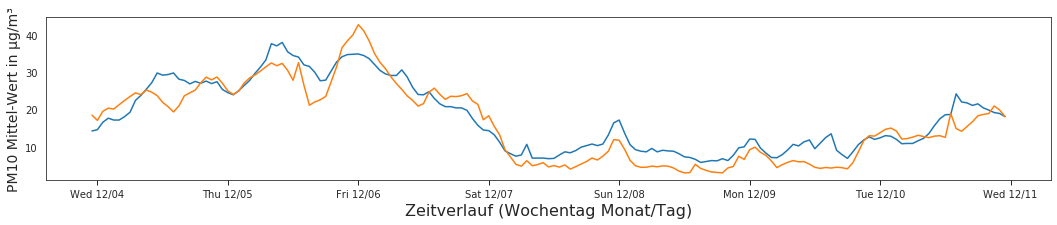

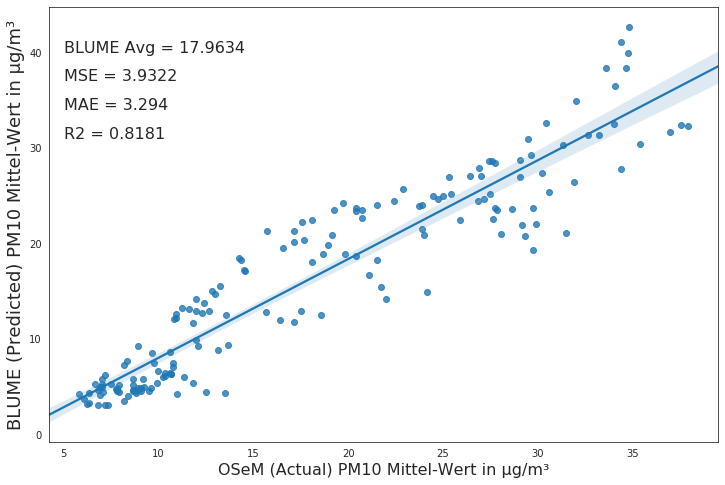

In [28]:
example_to_date = pd.Timestamp(2019,12,11)
example_to_date = pd.Timestamp(example_to_date, tz="CET")
#example_from_date = pd.Timestamp(2019,12,19)
example_from_date = (example_to_date-timedelta(days=7))
example_from_date = pd.Timestamp(example_from_date, tz="CET")

d_format = mdates.DateFormatter('%a %m/%d')

comp_week, metrics_week = compare_osem_blume(blume=df_blume_global, osem=df_osem_hours, start=example_from_date, end=example_to_date, verbose=True)

#Plot Timeseries
fig, ax1 = plt.subplots(figsize=(18, 3))
ax1.plot(comp_week)
ax1.set_ylabel('PM10 Mittel-Wert in µg/m³', fontsize=14)
ax1.set_xlabel('Zeitverlauf (Wochentag Monat/Tag)', fontsize=16)
ax1.xaxis.set_major_formatter(d_format)
ax1.tick_params(axis="both", direction="out", which="both", bottom=True, width=1, length=5)
#fig.suptitle('Berlinweiter, stündlicher Mittelwertvergleich OSEeM vs. BLUME für eine Dezember Woche', fontsize=20)
fig.savefig(graph_dir + "one_week_lineplot.png", transparent=True, bbox_inches="tight",pad_inches=0.1, dpi=200)
fig.show()

#(Sub)Plot Linear Regression
fig, ax1 = plt.subplots(figsize=(12, 8))
sns.regplot(x="BLUME", y="OSeM", data=comp_week, ax=ax1)
#ax1.set_title("Lineare Regression (Actual by Predicted Plot)")
ax1.set_xlabel('OSeM (Actual) PM10 Mittel-Wert in µg/m³', fontsize=16)
ax1.set_ylabel('BLUME (Predicted) PM10 Mittel-Wert in µg/m³', fontsize=18)
ax1.text(5, 40, fontsize=16, s=('BLUME Avg = {}'.format(round(metrics_week["BLUMEAVG"],4))))
ax1.text(5, 37, fontsize=16, s=('MSE = {}'.format(round(np.sqrt(metrics_week["MSE"]),4))))
ax1.text(5, 34, fontsize=16, s=('MAE = {}'.format(round(metrics_week["MAE"],4))))
ax1.text(5, 31, fontsize=16, s=('R2 = {}'.format(round(metrics_week["R2"],4))))
fig.savefig(graph_dir + "one_week_regplot.png", transparent=True, bbox_inches="tight",pad_inches=0.1, dpi=200)
fig.show()
#(Sub)Plot 
#TODO

#plt.subplot(122)  #sublot(Anzahl Zeilen Anzahl Spalten Bild Nummer)

**Erkentnisse**
Bei der Betrachteten Woche vom 04.12.2019-00:00 bis 11.12.2019-00:00 ergeben sich deutlich verbesserte Werte, als noch beim Monatsvergleich. Alle Metriken werden durchweg besser, jedoch sinkt der MAE "nur" von 5.5789 (Monatsvergleich) auf 3.2554 (Wochenvergleich). Der R2-Wert liegt mit 0.8081 im oberen Bereich.

### Test 3: Entwicklung der Metriken über den gesamten Zeitraum
**Vorgang**
Um Besser zu verstehen, wie sich die Metriken über einen längeren Zeitraum entwickeln, sollen über de gesamten Zeitraum des Datenbestands visualisiert werden. Berechne pro Tag den vergleichenden R2 Wert von BLUME vs. OSeM und plotte das Ergebniss.

In [29]:
#Select the latest and the first date in the Dataset
#start = df_blume_global.iloc[:1, :].index[0].to_pydatetime().date()
#end = df_osem_hours.iloc[-1:, :].index[0].to_pydatetime().date()

#Deduct some days as Puffer
start = pd.Timestamp(2019,11,24,0,0,0)
start = pd.Timestamp(start, tz="CET")
end = pd.Timestamp(2020,1,25,23,59,59)
end = pd.Timestamp(end, tz="CET")

#Define Range and create Series
days = (end-start).days
daily_metrics = dict()
weekly_metrics = dict()

#Compute 24h Metrics
for i in range(days):
    start_batch = start+timedelta(days=i)
    end_batch =  start+timedelta(days=i+1)
    comp_week, temp_metrics = compare_osem_blume(blume=df_blume_global, osem=df_osem_hours, start=start_batch, end=end_batch)
    daily_metrics[end_batch] = temp_metrics

#Go One Week Back to aggregate
start = start-timedelta(days=6)
#Compute 7 Days Metrics
for j in range(days):
    start_batch = start+timedelta(days=j)
    end_batch =  start+timedelta(days=j+7)
    comp_week, temp_metrics = compare_osem_blume(blume=df_blume_global, osem=df_osem_hours, start=start_batch, end=end_batch)
    weekly_metrics[end_batch] = temp_metrics

    
#Convert everything to DataFrame
weekly_metrics_df = pd.DataFrame(data=weekly_metrics.values(), index=weekly_metrics.keys())
daily_metrics_df = pd.DataFrame(data=daily_metrics.values(), index=daily_metrics.keys())


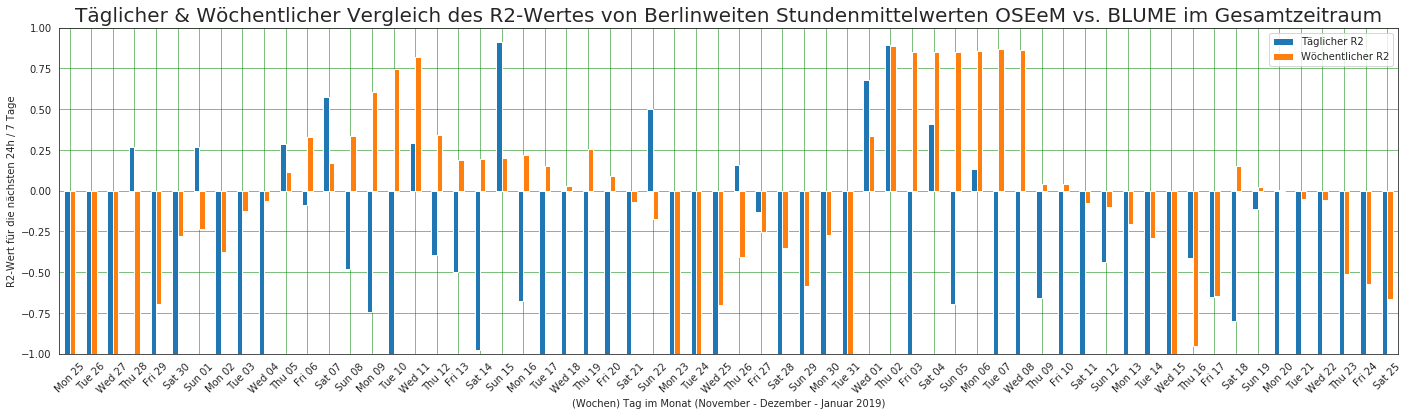

In [30]:
plot_data = pd.concat([daily_metrics_df["R2"],weekly_metrics_df["R2"]], axis=1)
plot_data.columns = ['Täglicher R2', 'Wöchentlicher R2']
plot_data.index = plot_data.index.strftime("%a %d")
plot_data.plot(kind='bar',figsize=(24,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.ylim(-1,1)
plt.xticks(rotation=45)
plt.title('Täglicher & Wöchentlicher Vergleich des R2-Wertes von Berlinweiten Stundenmittelwerten OSEeM vs. BLUME im Gesamtzeitraum', fontsize=20)

plt.xlabel('(Wochen) Tag im Monat (November - Dezember - Januar 2019)')
plt.ylabel('R2-Wert für die nächsten 24h / 7 Tage')



plt.legend()

plt.show()


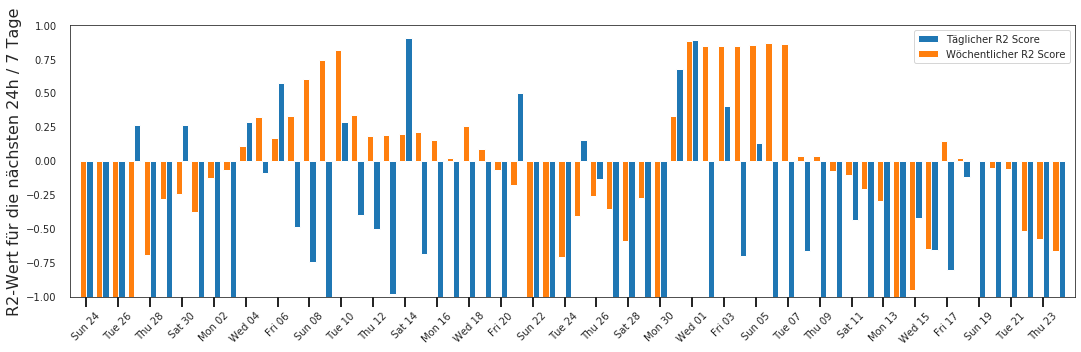

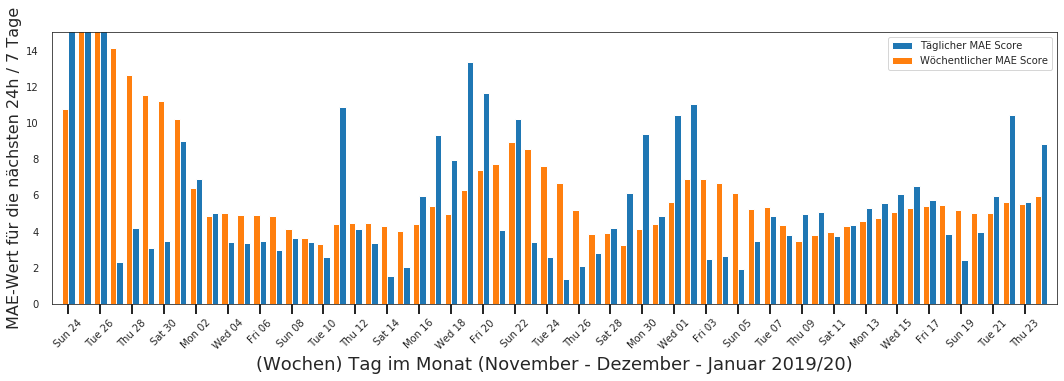

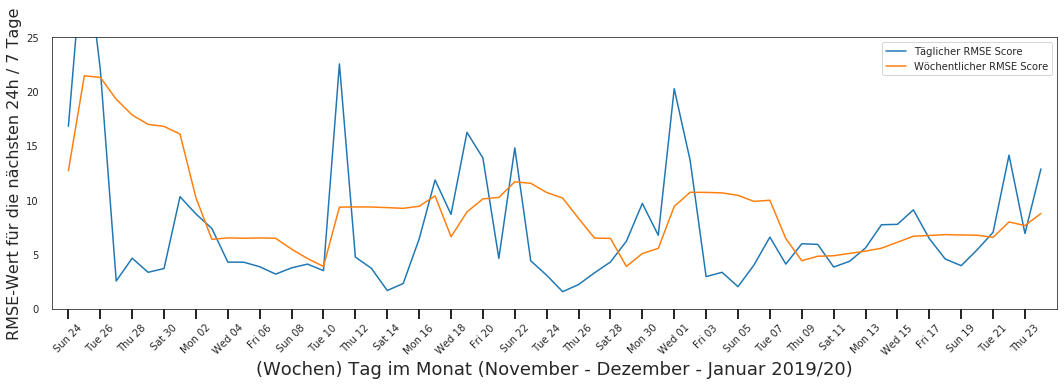

In [31]:
#Plot Timeseries
x = date2num(daily_metrics_df.index)
x_ticks = x[::2]
w=0.4
d_format = mdates.DateFormatter('%a %d')
x_label_size=18
y_label_size=16



fig, ax1 = plt.subplots(figsize=(18, 5))
ax1.bar(x+(w/2), daily_metrics_df["R2"], label='Täglicher R2 Score', width=w)
ax1.bar(x-(w/2), weekly_metrics_df["R2"], label='Wöchentlicher R2 Score', width=w)
ax1.xaxis.set_ticks(x_ticks)
ax1.xaxis.set_major_formatter(d_format)
ax1.set_xticklabels(x_ticks, rotation=45)
ax1.set_ylim(-1,1)
ax1.set_xlim(x[0]-1, x[-1]+1)
#ax1.set_title("Tägliche und Wöchentliche Entwicklung des R2-Wertes")
#ax1.set_xlabel('(Wochen) Tag im Monat (November - Dezember - Januar 2019)', fontsize=x_label_size)
ax1.set_ylabel('R2-Wert für die nächsten 24h / 7 Tage', fontsize=y_label_size)
ax1.legend(loc='best')
ax1.xaxis.set_major_formatter(d_format)
ax1.tick_params(axis="both", direction="out", which="both", bottom=True, width=2, length=10)
fig.savefig(graph_dir + "comp_r2_day_week.png", transparent=True, bbox_inches="tight",pad_inches=0.1, dpi=200)

#Plot MAE
fig, ax2 = plt.subplots(figsize=(18, 5))
ax2.bar(x+(w/2), daily_metrics_df["MAE"], label='Täglicher MAE Score', width=w)
ax2.bar(x-(w/2), weekly_metrics_df["MAE"], label='Wöchentlicher MAE Score', width=w)
#ax2.plot(x, daily_metrics_df["MAE"], label='Täglicher MAE Score')
#ax2.plot(x, weekly_metrics_df["MAE"], label='Wöchentlicher MAE Score')
ax2.xaxis.set_ticks(x_ticks)
ax2.xaxis.set_major_formatter(d_format)
ax2.set_xticklabels(x_ticks, rotation=45)
ax2.set_ylim(0,15)
ax2.set_xlim(x[0]-1, x[-1]+1)
#ax2.set_title("Tägliche und Wöchentliche Entwicklung des MAE-Wertes")
ax2.set_xlabel('(Wochen) Tag im Monat (November - Dezember - Januar 2019/20)', fontsize=x_label_size)
ax2.set_ylabel('MAE-Wert für die nächsten 24h / 7 Tage', fontsize=y_label_size)
ax2.legend(loc='best')
ax2.xaxis.set_major_formatter(d_format)
ax2.tick_params(axis="both", direction="out", which="both", bottom=True, width=2, length=10)
fig.savefig(graph_dir + "comp_mae_day_week.png", transparent=True, bbox_inches="tight",pad_inches=0.1, dpi=200)

#Plot MSE
fig, ax3 = plt.subplots(figsize=(18, 5))
#ax3.bar(x+(w/2), np.sqrt(daily_metrics_df["MSE"]), label='Täglicher RMSE Score', width=w)
#ax3.bar(x-(w/2), np.sqrt(weekly_metrics_df["MSE"]), label='Wöchentlicher RMSE Score', width=w)
ax3.plot(x, np.sqrt(daily_metrics_df["MSE"]), label='Täglicher RMSE Score')
ax3.plot(x, np.sqrt(weekly_metrics_df["MSE"]), label='Wöchentlicher RMSE Score')
ax3.xaxis.set_ticks(x_ticks)
ax3.xaxis.set_major_formatter(d_format)
ax3.set_xticklabels(x_ticks, rotation=45)
ax3.set_ylim(0,25)
ax3.set_xlim(x[0]-1, x[-1]+1)
#ax3.set_title("Tägliche und Wöchentliche Entwicklung des RMSE-Wertes")
ax3.set_xlabel('(Wochen) Tag im Monat (November - Dezember - Januar 2019/20)', fontsize=x_label_size)
ax3.set_ylabel('RMSE-Wert für die nächsten 24h / 7 Tage', fontsize=y_label_size)
ax3.legend(loc='best')
ax3.xaxis.set_major_formatter(d_format)
ax3.tick_params(axis="both", direction="out", which="both", bottom=True, width=2, length=10)
fig.savefig(graph_dir + "comp_rmse_day_week.png", transparent=True, bbox_inches="tight",pad_inches=0.1, dpi=200)


plt.show()



### Vergleiche Stundenmittel mithilfe MLR

In [19]:
def remove_nans(data, time_threshold=30, sensor_threshold=30, verbose=False):
    #--------Sensor Section starts-----------
    initial_sensors = data.shape[1]
    #Get percentage of how Many NAN Values per Sensor
    percentage = data.isna().mean().round(4) * 100
    #Create a Mask with Sensors below Threshold (e.g. max. 30% NAN Values)
    mask = percentage<sensor_threshold
    #Get the Index of all "Quality" Sensors
    mask = mask[mask == True].index
    #Do some Statistics to measure the peak NAN-Sensors
    peak_sensor_before = percentage.sort_values(ascending=False)[0]
    #Remove The Sensors with the previously generated mask
    data = data[mask]
    #Statistics on how many Sensors were deleted
    removed_sensors = initial_sensors-data.shape[1]
    percentage = data.isna().mean().round(4) * 100
    peak_sensor_after = (percentage.sort_values(ascending=False))[0]

    #--------Time Section starts-----------
    initial_times = data.shape[0]
    #Get percentage of how Many NAN Values per Time-Index
    percentage = data.isna().mean(axis=1).round(4) * 100
    #Create a Mask with Time-Indicies below Threshold (e.g. max. 30% NAN Values)
    mask = percentage<time_threshold
    #Get the Index of all "Quality" Time-Indices
    mask = mask[mask == True].index
    #Do some Statistics to measure the peak NAN-Sensors
    peak_time_before = percentage.sort_values(ascending=False)[0]
    #Remove The Time-Indices with the previously generated mask
    data = data.loc[mask]
    #Statistics on how many Sensors were deleted
    removed_times = initial_times-data.shape[0]
    percentage = data.isna().mean(axis=1).round(4) * 100
    peak_time_after = (percentage.sort_values(ascending=False))[0]
    
    #--------Interpolation Section starts-----------
    #Interpolate NAN Values, first by Sensor, then by Time-Index
    nans_before = data.isna().sum().sum()
    data = data.where(pd.notna(data), data.interpolate(axis=0), axis='columns')
    data = data.where(pd.notna(data), data.interpolate(axis=1), axis='rows')
    nans_after = data.isna().sum().sum()

    if(verbose):
        print("---------- Removing Nan Columns/Rows ---------- ")
        print("Removed Sensors = {} / {}".format(removed_sensors, initial_sensors))
        print("Removed Hours = {}".format(removed_times, initial_times))
        print("Threshold for Timely NaNs = {}%".format(time_threshold))
        print("Threshold for Sensor NaNs = {}%".format(sensor_threshold))
        print("Before-After Peak in Percentage for Timely NaNs = {} --> {}".format(peak_time_before, peak_time_after))
        print("Before-After Peak in Percentage for Sensor NaNs = {} --> {}".format(peak_sensor_before, peak_sensor_after))
        print("---------- Interpolation Nan Columns/Rows ---------- ")
        print("NaNs Before / After Interpolation = {} / {}".format(nans_before, nans_after))
    return data

In [20]:
def remove_nans_series(data, time_threshold=30, verbose=False):
    #--------Time Section starts-----------
    initial_times = data.shape[0]
    #Get percentage of how Many NAN Values per Time-Index
    percentage = data.isna().mean(axis=1).round(4) * 100
    #Create a Mask with Time-Indicies below Threshold (e.g. max. 30% NAN Values)
    mask = percentage<time_threshold
    #Get the Index of all "Quality" Time-Indices
    mask = mask[mask == True].index
    #Do some Statistics to measure the peak NAN-Sensors
    peak_time_before = percentage.sort_values(ascending=False)[0]
    #Remove The Time-Indices with the previously generated mask
    data = data.loc[mask]
    #Statistics on how many Sensors were deleted
    removed_times = initial_times-data.shape[0]
    percentage = data.isna().mean(axis=1).round(4) * 100
    peak_time_after = (percentage.sort_values(ascending=False))[0]
    
    #--------Interpolation Section starts-----------
    #Interpolate NAN Values, first by Sensor, then by Time-Index
    nans_before = data.isna().sum().sum()
    data = data.where(pd.notna(data), data.interpolate(axis=0), axis='columns')
    data = data.where(pd.notna(data), data.interpolate(axis=1), axis='rows')
    nans_after = data.isna().sum().sum()

In [21]:
def hourly_mlr(osem, blume, start=None, end=None, test_size=0.02, random_state=48, verbose=False):
    """
    params:
        osem: hourly OSeM Means of multiple Sensors in a DataFrame
        blume: hourly BLUME Mean for Berlin (1 Value per Hour)
    """
    #If Time-Frame is given, cut Dataset
    if(start and end):
        osem = osem.loc[start:end]  
    
    #Remove Rows/Colums with high percentage of NAN Values 
    osem = remove_nans(osem, verbose=True)
    
    #Use Only Data which is availaible in both Datasets
    intersec = blume.index.intersection(osem.index)
    blume = blume.loc[intersec]
    osem = osem.loc[intersec]
    
    #Convert both datasets to numpy
    X = osem.to_numpy()
    y = blume.to_numpy()    
    
    #Gruppiere alle Stationen zusammen per Mittelwert (Betrachte Berlin, nicht einzelne Stationen)
    X_train, X_test, y_train, y_test = train_test_split(osem, blume, test_size=24, random_state=random_state, shuffle=False)

    # with sklearn
    regr = LinearRegression()
    regr.fit(X_train, y_train)
    
    #Generate Koeffizienten DataFrame
    coeff_df = pd.DataFrame(regr.coef_, osem.columns, columns=['Coefficient']) 
    coeff_df.sort_values(by='Coefficient')
    
    #Test Model
    y_pred = regr.predict(X_test)
    df_pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    
    #Metrics
    metrics_pred = {'Mean Value of Ground Truth Test Data': y_test, 
                    'R2 Score': y_pred,
                    'Mean Absolute Error': sklearn.metrics.mean_absolute_error(y_test, y_pred),
                    'Mean Squared Error': sklearn.metrics.mean_squared_error(y_test, y_pred),
                    'Root Mean Squared Error': np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred))
                   }
    
    if(verbose):
        print("\n ---------- Regression Info ----------")
        print("X-Train Shape:", X_train.shape)
        print("Y-Train Shape:", y_train.shape)
        print("X-Test Shape:",X_test.shape)
        print("Y-Test Shape:",y_test.shape)
        print('Intercept: \n', regr.intercept_)
        print('Mean Value of Ground Truth Test Data:', np.mean(y_test))
        print('R2 Score:', sklearn.metrics.r2_score(y_test, y_pred))
        print('Mean Absolute Error:', sklearn.metrics.mean_absolute_error(y_test, y_pred)) 
        print('Mean Squared Error:', sklearn.metrics.mean_squared_error(y_test, y_pred))  
        print('Root Mean Squared Error:', np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred)))


    return regr, coeff_df, df_pred, metrics_pred
    

In [22]:
start = pd.Timestamp(2019,11,25,1,0,0)
start = pd.Timestamp(start, tz="CET")
end = pd.Timestamp(2020,1,26, 0,0,0)
end = pd.Timestamp(end, tz="CET")

In [23]:
regression, coefficients_df, pred_df, metrics_df = hourly_mlr(df_osem_hours, df_blume_global.mean(axis=1), start=start, end=end, verbose=True)

---------- Removing Nan Columns/Rows ---------- 
Removed Sensors = 55 / 135
Removed Hours = 0
Threshold for Timely NaNs = 30%
Threshold for Sensor NaNs = 30%
Before-After Peak in Percentage for Timely NaNs = 16.25 --> 16.25
Before-After Peak in Percentage for Sensor NaNs = 100.0 --> 29.770000000000003
---------- Interpolation Nan Columns/Rows ---------- 
NaNs Before / After Interpolation = 6451 / 0

 ---------- Regression Info ----------
X-Train Shape: (1464, 80)
Y-Train Shape: (1464,)
X-Test Shape: (24, 80)
Y-Test Shape: (24,)
Intercept: 
 4.595532747655433
Mean Value of Ground Truth Test Data: 20.00347222222222
R2 Score: -0.2145112183338873
Mean Absolute Error: 3.005162277274652
Mean Squared Error: 13.442192710606315
Root Mean Squared Error: 3.6663595991945903


In [24]:
coefficients_df.sort_values(by='Coefficient')

,Coefficient
5d6e465a953683001a2b62c7_PM10,-0.292060
5aa68042396417001bcc3503_PM10,-0.224703
5c01686bccc67b001c8a2eff_PM10,-0.217895
5cf9874107460b001b828c60_PM10,-0.192076
5c1d220a919bf8001ad93502_PM10,-0.142220
...,...
5a7f2eb1398b82001189eb69_PM10,0.709031
5a915e10bc2d410019b1955c_PM10,0.923516
5c01676accc67b001c89f9f1_PM10,1.731330
5bf837bf86f11b001aae7f84_PM10,6.024230


In [25]:
pred_df

,Actual,Predicted
2020-01-25 01:00:00+01:00,26.750000,28.187779
2020-01-25 02:00:00+01:00,23.666667,23.929407
2020-01-25 03:00:00+01:00,20.333333,19.683465
2020-01-25 04:00:00+01:00,17.916667,21.460089
2020-01-25 05:00:00+01:00,16.666667,21.121527
2020-01-25 06:00:00+01:00,17.250000,17.993853
2020-01-25 07:00:00+01:00,16.083333,18.749055
2020-01-25 08:00:00+01:00,15.500000,17.601720
2020-01-25 09:00:00+01:00,17.500000,19.273393
2020-01-25 10:00:00+01:00,18.583333,21.473522


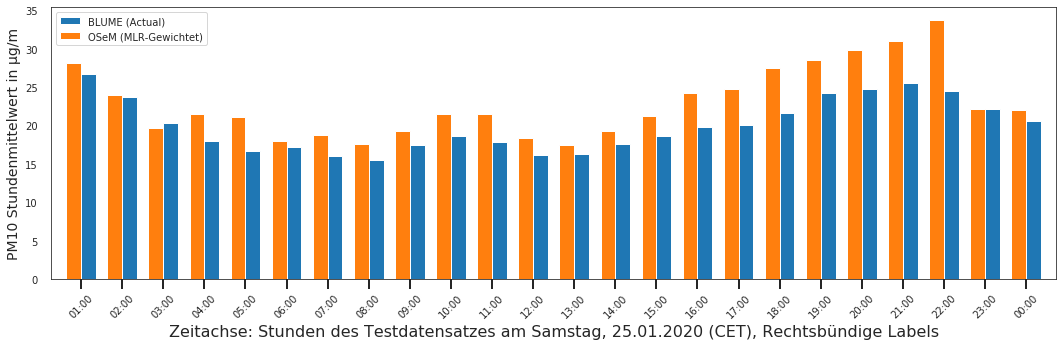

In [26]:
#Plot Timeseries
x = date2num(pred_df.index)
w=0.015
d_format = mdates.DateFormatter('%H:%M', tz=cet)

fig, ax1 = plt.subplots(figsize=(18, 5))
ax1.bar(x+(w/2), pred_df["Actual"], label='BLUME (Actual)', width=w)
ax1.bar(x-(w/2), pred_df["Predicted"], label='OSeM (MLR-Gewichtet)', width=w)
ax1.set_xlim(x[0]-2*w, x[-1]+2*w)
ax1.xaxis.set_ticks(x)
ax1.xaxis.set_major_formatter(d_format)
ax1.set_xticklabels(x, rotation=45)
#ax1.set_ylim(-1,1)
#ax1.set_title("Vergleich: Mit MLR gewichtete OSeM-Werte auf Basis der BLUME Test-Daten (Datenauflösung: Berlinweit, stündlich)")
ax1.set_xlabel('Zeitachse: Stunden des Testdatensatzes am Samstag, 25.01.2020 (CET), Rechtsbündige Labels', fontdict = {"size":16})
ax1.set_ylabel('PM10 Stundenmittelwert in µg/m', fontdict = {"size":14})
ax1.tick_params(axis="both", direction="out", which="both", bottom=True, width=2, length=10)


ax1.legend(loc='best')
ax1.xaxis.set_major_formatter(d_format)

fig.savefig(graph_dir + "Simple_MLR_Correction.png", transparent=True, bbox_inches="tight",pad_inches=0.1, dpi=200)
plt.show()


### Versuche Crossvalidation um die Ergebnisse zu Verifizieren

Die Ergebnisse der MLR Rechnung schauen sehr gut aus. Aber sind Sie wirklich representativ für den ganzen Datensatz? Es wird ja nur ein Ausschnitt von gut 24 Stunden als Test genutzt, weswegen das Model ein starkes Overfit haben könnte. Mit der Cross-Validation wird der Datensatz immer nach 24 Stunden abgeschnitten und iterativ das ganze Feld nach und nach geprüft. So kann ein möglicher Overfit erkannt werden.

In [27]:
def hourly_regr_cv(osem, blume, regr, start=None, end=None, split_hours=24, verbose=False):
    """
    params:
        osem: hourly OSeM Means of multiple Sensors in a DataFrame
        blume: hourly BLUME Mean for Berlin (1 Value per Hour)
    """
    #If Time-Frame is given, cut Dataset
    if(start and end):
        osem = osem.loc[start:end] 
    
    #Remove Rows/Colums with high percentage of NAN Values 
    logging.info("---------- Removing OSeM Nans ----------")
    osem = remove_nans(osem, verbose=True)
    logging.info("---------- Removing BLUME Nans ----------")
    #blume = remove_nans(blume, verbose=True)
    
    #Use Only Data which is availaible in both Datasets
    intersec = blume.index.intersection(osem.index)
    blume = blume.loc[intersec]
    osem = osem.loc[intersec]    
    
    #Check if whole Days are provided. Otherwise calculations my be faulty.
    if(osem.shape[0] % 24 != 0):
        logging.error("OSeM Shape = {} % 24 = {}".format(osem.shape[0], (osem.shape[0] % 24) ))
        logging.error("BLUME Shape = {} % 24 = {}".format(blume.shape[0], (blume.shape[0] % 24) ))
        raise AttributeError("Amount of Hours is not dividable by 24!") 
    
    #Convert both datasets to numpy
    X = osem.to_numpy()
    y = blume.to_numpy()
    
    #Use Crossvalidation
    cv_scores = dict()
    
    #Split with the Amout of Days so every Test-Set has the Size = 24h
    splits = round(osem.shape[0]/split_hours)-1
    logging.info("Splits {}".format(splits))
    logging.info("# Indexes {}".format(osem.shape[0]))
    
    #Split Up Data into Train/Test Set. Using TimeSeriesSplit.
    #This Method splits up the Data iterative, for instance:  
    # 1) Train = 1,2 Test = 3 || 2) Train = 1, 2, 3 Test= 4 || 3) Train = 1,2,3,4, Test = 5
    #The Test will always be a different set, but never exceeding Size = 1    
    tscv=TimeSeriesSplit(n_splits=splits)
    #DEBUG: Check the Indecies if correct
    for train_index, test_index in tscv.split(X):
        for index in train_index:
            logging.debug(blume.index[index])
        logging.debug("------------CUT------------")
        
    cv_scores["r2"] = cross_val_score(regr, X, y, cv=tscv, scoring="r2")
    cv_scores["mae"] = cross_val_score(regr, X, y, cv=tscv, scoring="neg_mean_absolute_error") 
    cv_scores["mse"] = cross_val_score(regr, X, y, cv=tscv, scoring="neg_mean_squared_error") 
    cv_scores["rmse"] = cross_val_score(regr, X, y, cv=tscv, scoring="neg_root_mean_squared_error")
    ground_truth_mean = y.mean()
    
    if(verbose):
        print("\n ---------- CV Info ----------")
        print("X-Size (Hours x Sensors):", X.shape)
        print("Number of Train/Test-Splits:", splits)
        print('Mean Value of Ground Truth Test Data:', ground_truth_mean)
        print('R2 Scores:', np.round(cv_scores["r2"],3))
        print('Mean Absolute Errors:', np.round(cv_scores["mae"],3))
        print('Mean Squared Errors:', np.round(cv_scores["mse"],3)  )
        print('Root Mean Squared Errors:', np.round(cv_scores["rmse"],3))
            


    return cv_scores, ground_truth_mean

In [28]:
regr = LinearRegression()
cross_vals_mlr, y_mean_mlr = hourly_regr_cv(df_osem_hours, df_blume_global.mean(axis=1), regr, start=start, end=end)

INFO:root:---------- Removing OSeM Nans ----------
INFO:root:---------- Removing BLUME Nans ----------
INFO:root:Splits 61
INFO:root:# Indexes 1488


---------- Removing Nan Columns/Rows ---------- 
Removed Sensors = 55 / 135
Removed Hours = 0
Threshold for Timely NaNs = 30%
Threshold for Sensor NaNs = 30%
Before-After Peak in Percentage for Timely NaNs = 16.25 --> 16.25
Before-After Peak in Percentage for Sensor NaNs = 100.0 --> 29.770000000000003
---------- Interpolation Nan Columns/Rows ---------- 
NaNs Before / After Interpolation = 6451 / 0


In [29]:
cross_vals_mlr_df = pd.DataFrame(cross_vals_mlr)
print("Regard Overall Sets")
print(cross_vals_mlr_df.mean())
print("Regard only the Last 7 Sets")
print(cross_vals_mlr_df.iloc[-7:,:].mean())
cross_vals_mlr_df.tail(10)

Regard Overall Sets
r2       -1.440706
mae      -4.298446
mse    -218.777047
rmse     -5.851835
dtype: float64
Regard only the Last 7 Sets
r2      -0.275784
mae     -2.456228
mse    -12.719198
rmse    -3.368560
dtype: float64


,r2,mae,mse,rmse
51,0.588384,-2.751837,-21.489187,-4.635643
52,0.711878,-2.073082,-6.935936,-2.633616
53,0.897108,-0.944136,-1.411130,-1.187910
54,0.161037,-1.124570,-2.252048,-1.500682
55,0.432978,-2.127953,-7.914030,-2.813189
56,-3.871269,-2.999770,-29.397487,-5.421945
57,0.910951,-2.142669,-6.279552,-2.505903
58,0.172527,-3.133027,-17.945801,-4.236248
59,0.477796,-2.660447,-11.803278,-3.435590
60,-0.214511,-3.005162,-13.442193,-3.666360


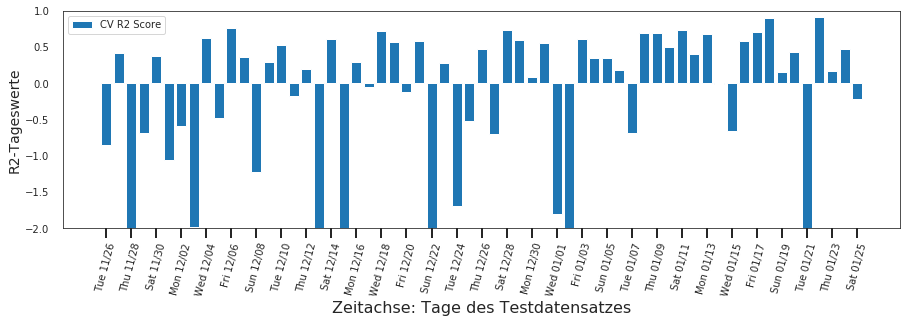

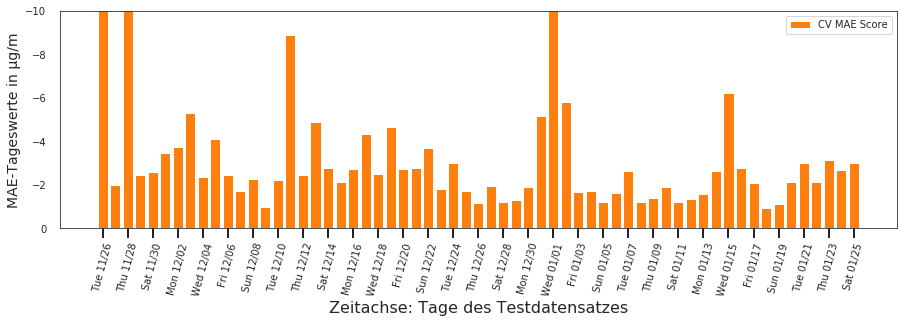

In [33]:
#Plot Timeseries
datelist = pd.DatetimeIndex(pd.date_range(start+timedelta(days=1), end))
x = date2num(datelist)
x_ticks = x[::2]
w=0.8
d_format = mdates.DateFormatter('%a %m/%d')

fig, ax1 = plt.subplots(figsize=(15, 4))

ax1.bar(x, cross_vals_mlr_df["r2"], label='CV R2 Score', width=w, color="C0")
ax1.set_xticks(x_ticks)
ax1.tick_params(axis="both", direction="out", which="both", bottom=True, width=2, length=10)
ax1.set_xticklabels(x_ticks, rotation=75)
ax1.xaxis.set_major_formatter(d_format)
ax1.set_ylim(-2,1)
#ax1.set_title("Tägliche Entwicklung des R2-Wertes mittels MLR und Cross Validation (Datenauflösung: Berlinweit, stündlich)")
ax1.set_xlabel('Zeitachse: Tage des Testdatensatzes', fontdict = {"size":16})
ax1.set_ylabel('R2-Tageswerte', fontdict = {"size":14})
ax1.legend(loc='best')
#ax1.text(45,-1.5, fontsize=2, s=('R2 Avg = {}'.format(round(cross_vals_mlr_df["r2"].mean(),4))))
fig.savefig(graph_dir + "CV_MLR_R2.png", transparent=True, bbox_inches="tight",pad_inches=0.1, dpi=200)


fig, ax2 = plt.subplots(figsize=(15, 4))
ax2.bar(x, cross_vals_mlr_df["mae"], label='CV MAE Score', width=w, color="C1")
ax2.set_xticks(x_ticks)
ax2.tick_params(axis="both", direction="out", which="both", bottom=True, width=2, length=10)
ax2.set_xticklabels(x_ticks, rotation=75)
ax2.xaxis.set_major_formatter(d_format)
ax2.set_ylim(0,-10)
#ax2.text(45,-8, fontsize=16, s=('MAE Avg = {}'.format(round(cross_vals_mlr_df["mae"].mean(),4))))
#ax2.set_title("Tägliche Entwicklung des MAE mittels MLR und Cross Validation (Datenauflösung: Berlinweit, stündlich)")
ax2.set_xlabel('Zeitachse: Tage des Testdatensatzes', fontdict = {"size":16})
ax2.set_ylabel('MAE-Tageswerte in µg/m', fontdict = {"size":14})
#ax2.xaxis.set_major_formatter(d_format)
ax2.legend(loc='best')
fig.savefig(graph_dir + "CV_MLR_MAE.png", transparent=True, bbox_inches="tight",pad_inches=0.1, dpi=200)

plt.show()


### Random Forest Model
Im nächsten Schritt soll Versucht werden, die Ergebnisse aus der MLR zu verbessern mithilfe eines Random-Forest Modells

In [34]:
rand_forest_regr = RandomForestRegressor(n_estimators=500, random_state=0, max_depth=80, max_features="auto", min_samples_split=2, min_samples_leaf=3)
cross_vals_berlin_rf, y_mean = hourly_regr_cv(df_osem_hours, df_blume_global.mean(axis=1), rand_forest_regr, start=start, end=end, verbose=True)

INFO:root:---------- Removing OSeM Nans ----------
INFO:root:---------- Removing BLUME Nans ----------
INFO:root:Splits 61
INFO:root:# Indexes 1488


---------- Removing Nan Columns/Rows ---------- 
Removed Sensors = 55 / 135
Removed Hours = 0
Threshold for Timely NaNs = 30%
Threshold for Sensor NaNs = 30%
Before-After Peak in Percentage for Timely NaNs = 16.25 --> 16.25
Before-After Peak in Percentage for Sensor NaNs = 100.0 --> 29.770000000000003
---------- Interpolation Nan Columns/Rows ---------- 
NaNs Before / After Interpolation = 6451 / 0

 ---------- CV Info ----------
X-Size (Hours x Sensors): (1488, 80)
Number of Train/Test-Splits: 61
Mean Value of Ground Truth Test Data: 19.06899132453568
R2 Scores: [-1.2410e+00 -3.4140e+00 -1.0154e+01  6.8700e-01  5.7100e-01  3.0400e-01
 -1.3890e+00  1.8800e-01 -3.1800e-01 -1.6680e+00  6.9400e-01  7.5600e-01
  7.0300e-01  1.7100e-01  5.2900e-01 -2.5700e-01  5.1200e-01  2.5600e-01
  8.6200e-01  2.0500e-01  3.2600e-01 -5.8300e-01  4.5300e-01  5.3300e-01
  9.9000e-02  8.5700e-01 -4.7700e-01 -7.8600e-01 -2.7420e+00 -2.1560e+00
  6.9900e-01  7.5000e-01  7.8800e-01  5.3300e-01 -6.4100e-01  5.7

Estimations

In [35]:
cross_vals_berlin_rf_df = pd.DataFrame(cross_vals_berlin_rf)
print(cross_vals_berlin_rf_df.mean())
print(cross_vals_berlin_rf_df.iloc[-7:,:].mean())
#Regard only the Last 7 Sets
cross_vals_berlin_rf_df.tail(7)

r2      -0.215138
mae     -3.303926
mse    -86.112306
rmse    -4.879365
dtype: float64
r2      -0.490085
mae     -3.515144
mse    -21.567644
rmse    -4.298856
dtype: float64


,r2,mae,mse,rmse
54,0.003577,-1.290277,-2.674720,-1.635457
55,0.307267,-2.687001,-9.668588,-3.109435
56,-1.724251,-2.862219,-16.440503,-4.054689
57,0.312872,-5.187962,-48.455105,-6.960970
58,0.306894,-3.133881,-15.031723,-3.877077
59,0.360101,-2.861658,-14.463522,-3.803094
60,-2.997055,-6.583007,-44.239347,-6.651267


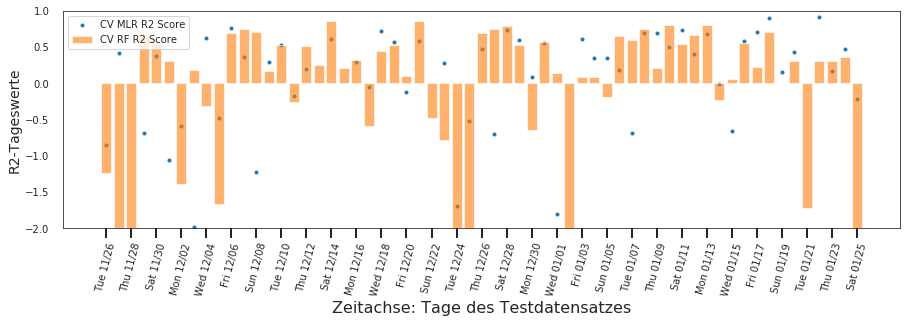

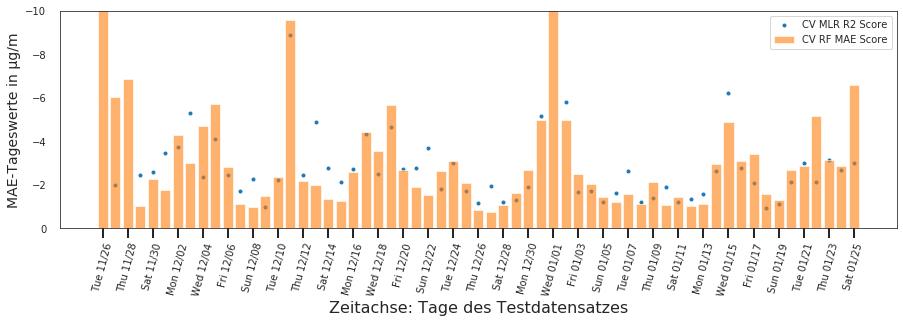

In [39]:
#Plot Timeseries
datelist = pd.DatetimeIndex(pd.date_range(start+timedelta(days=1), end))
x = date2num(datelist)
x_ticks = x[::2]
w=0.8
d_format = mdates.DateFormatter('%a %m/%d')

fig, ax1 = plt.subplots(figsize=(15, 4))

ax1.scatter(x, cross_vals_mlr_df["r2"], label='CV MLR R2 Score', color="C0", marker=".")
ax1.bar(x, cross_vals_berlin_rf_df["r2"], label='CV RF R2 Score', color="C1", alpha=0.6)
ax1.set_xticks(x_ticks)
ax1.tick_params(axis="both", direction="out", which="both", bottom=True, width=2, length=10)
ax1.set_xticklabels(x_ticks, rotation=75)
ax1.xaxis.set_major_formatter(d_format)
ax1.set_ylim(-2,1)
#ax1.set_title("Tägliche Entwicklung des R2-Wertes mittels Random Forest und Cross Validation (Datenauflösung: Berlinweit, stündlich)")
ax1.set_xlabel('Zeitachse: Tage des Testdatensatzes', fontdict = {"size":16})
ax1.set_ylabel('R2-Tageswerte', fontdict = {"size":14})
#ax1.text(45,-1.5, fontsize=2, s=('R2 Avg = {}'.format(round(cross_vals_mlr_df["r2"].mean(),4))))
ax1.legend(loc='best')
fig.savefig(graph_dir + "CV_RF_R2.png", transparent=True, bbox_inches="tight",pad_inches=0.1, dpi=200)


fig, ax2 = plt.subplots(figsize=(15, 4))
ax2.bar(x, cross_vals_berlin_rf_df["mae"], label='CV RF MAE Score', width=w, color="C1", alpha=0.6)
ax2.scatter(x, cross_vals_mlr_df["mae"], label='CV MLR R2 Score', color="C0", marker=".")
ax2.set_xticks(x_ticks)
ax2.tick_params(axis="both", direction="out", which="both", bottom=True, width=2, length=10)
ax2.set_xticklabels(x_ticks, rotation=75)
ax2.xaxis.set_major_formatter(d_format)
ax2.set_ylim(0,-10)
#ax2.text(45,-8, fontsize=16, s=('MAE Avg = {}'.format(round(cross_vals_mlr_df["mae"].mean(),4))))
#ax2.set_title("Tägliche Entwicklung des MAE mittels Random Forest und Cross Validation (Datenauflösung: Berlinweit, stündlich)")
ax2.set_xlabel('Zeitachse: Tage des Testdatensatzes', fontdict = {"size":16})
ax2.set_ylabel('MAE-Tageswerte in µg/m', fontdict = {"size":14})
ax2.legend(loc='best')
fig.savefig(graph_dir + "CV_RF_MAE.png", transparent=True, bbox_inches="tight",pad_inches=0.1, dpi=200)
plt.show()


Random Hyperparameter Tuning

In [203]:
def random_tuning(osem, blume, regr, random_grid, start=None, end=None, split_hours=24, verbose=False):
    """
    params:
        osem: hourly OSeM Means of multiple Sensors in a DataFrame
        blume: hourly BLUME Mean for Berlin (1 Value per Hour)
    """
    #If Time-Frame is given, cut Dataset
    if(start and end):
        osem = osem.loc[start:end] 
    
    #Remove Rows/Colums with high percentage of NAN Values 
    osem = remove_nans(osem, verbose=False)
    
    #Use Only Data which is availaible in both Datasets
    intersec = blume.index.intersection(osem.index)
    blume = blume.loc[intersec]
    osem = osem.loc[intersec]    
    
    #Check if whole Days are provided. Otherwise calculations my be faulty.
    if(osem.shape[0] % 24 != 0):
        raise AttributeError("Amount of Hours is not dividable by 24!") 
    
    #Convert both datasets to numpy
    X = osem.to_numpy()
    y = blume.to_numpy()
    
    #Use Crossvalidation
    cv_scores = dict()
    
    #Split with the Amout of Days so every Test-Set has the Size = 24h
    splits = round(osem.shape[0]/split_hours)-1
    logging.info("Splits {}".format(splits))
    logging.info("# Indexes {}".format(osem.shape[0]))
    
    #Split Up Data into Train/Test Set. Using TimeSeriesSplit.
    #This Method splits up the Data iterative, for instance:  
    # 1) Train = 1,2 Test = 3 || 2) Train = 1, 2, 3 Test= 4 || 3) Train = 1,2,3,4, Test = 5
    #The Test will always be a different set, but never exceeding Size = 1    
    tscv=TimeSeriesSplit(n_splits=splits)

    rf_random = RandomizedSearchCV(estimator = regr, param_distributions = random_grid, n_iter = 30, cv = tscv, random_state=0, n_jobs = -1, verbose=2)
    # Fit the random search model
    rf_random.fit(X, y)
    return rf_random

In [204]:
def start_hyper_tuning():
    rand_forest_regr = RandomForestRegressor()


    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 20, stop = 2000, num = 5)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt', 'log2']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]

    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

    rand1 = random_tuning(df_osem_hours, df_blume_global.mean(axis=1), rand_forest_regr, random_grid, start=start, end=end)
    return rand1

#hyper_results = start_hyper_tuning()

In [99]:
def manual_rf_cv_validation():
    delta_test = 1
    start1 = start
    end1 = end-timedelta(days=delta_test)
    end2 = end-timedelta(days=delta_test-1)
    print(end2-start)
    rand_forest_regr = RandomForestRegressor(n_estimators=200, random_state=0, max_features="log2")
    os1 = remove_nans(df_osem_hours[start1:end2], verbose=False)
    bl1 = df_blume_global.mean(axis=1)[start1:end2]

    #Use Only Data which is availaible in both Datasets
    intersec = bl1.index.intersection(os1.index)
    bl1 = bl1.loc[intersec]
    os1 = os1.loc[intersec]

    X_train, X_test, y_train, y_test = os1[start1:end1], os1[end1:end2], bl1[start1:end1], bl1[end1:end2]
    #Train the model using the training sets y_pred=clf.predict(X_test)
    rand_forest_regr.fit(X_train,y_train)
    y_pred=rand_forest_regr.predict(X_test)

    r2_current = sklearn.metrics.r2_score(y_true=y_test, y_pred=y_pred)
    mae_current = sklearn.metrics.mean_absolute_error(y_true=y_test, y_pred=y_pred)
    mse_current = sklearn.metrics.mean_squared_error(y_true=y_test, y_pred=y_pred)

    metrics_current = {"R2":r2_current, "MAE":mae_current, "MSE":mse_current}
    
    return metrics_current, rand_forest_regr

manual_metrics, manual_rf = manual_rf_cv_validation()

53 days 23:00:00


In [206]:
def feature_selector():
    delta_test = 1
    start1 = start
    end1 = end-timedelta(days=delta_test)
    end2 = end-timedelta(days=delta_test-1)
    print(end2-start)
    rand_forest_regr = RandomForestRegressor(n_estimators=200, random_state=0, max_features="log2")
    os1 = remove_nans(df_osem_hours[start1:end2], verbose=False)
    bl1 = df_blume_global.mean(axis=1)[start1:end2]

    #Use Only Data which is availaible in both Datasets
    intersec = bl1.index.intersection(os1.index)
    bl1 = bl1.loc[intersec]
    os1 = os1.loc[intersec]

    X_train, X_test, y_train, y_test = os1[start1:end1], os1[end1:end2], bl1[start1:end1], bl1[end1:end2]
    #Train the model using the training sets y_pred=clf.predict(X_test)
    rand_forest_regr.fit(X_train,y_train)
    y_pred=rand_forest_regr.predict(X_test)
    
    sfm = SelectFromModel(rand_forest_regr, threshold=0.01)

    # Train the selector
    sfm.fit(X_train, y_train)
    
    for feature_list_index in sfm.get_support(indices=True):
        pass
        #print(X_train.iloc[:, feature_list_index].name)
        
    X_important_train = sfm.transform(X_train)
    X_important_test = sfm.transform(X_test)
    
    # Create a new random forest classifier for the most important features
    rand_forest_regr_important = RandomForestRegressor(n_estimators=200, random_state=0, max_features="log2")

    # Train the new classifier on the new dataset containing the most important features
    rand_forest_regr_important.fit(X_important_train, y_train)
    y_important_pred=rand_forest_regr_important.predict(X_important_test)
    
    r2_current = sklearn.metrics.r2_score(y_true=y_test, y_pred=y_important_pred)
    mae_current = sklearn.metrics.mean_absolute_error(y_true=y_test, y_pred=y_important_pred)
    mse_current = sklearn.metrics.mean_squared_error(y_true=y_test, y_pred=y_important_pred)

    metrics_current = {"R2":r2_current, "MAE":mae_current, "MSE":mse_current}
    
    return sfm, rand_forest_regr_important, metrics_current

feature_select, manual_rf, metrics = feature_selector()
metrics

53 days 23:00:00


{'R2': 0.9068108937921087,
 'MAE': 1.1499469696969689,
 'MSE': 1.7780212251492173}

## Vorhersage für jeden BLUME Standort individuell
Versuche nicht mehr Gesamt-Berliner Mittelwerte vorherzusagen, sondern gezielt einzelne Sensoren vorherzusagen. Quasi eine Inselvorhersage. Dabei soll der Algorithmus eigenständig herausfinden, welche OSeM Sensoren für welche BLUME Messtationen besonders geeignet sind zur Vorhersage.
Bei der Betrachtung der Ergebnisse werden immer nur die Mittelwerte der letzten 7 Tage betrachtet. An diesen Tagen hatte das Model genügend Zeit zu trainieren.

In [110]:
len( df_blume_global.iloc[:,1].shape)

1

In [346]:
blume_count = df_blume_global.shape[1]
#rand_fr = RandomForestRegressor(n_estimators=20, random_state=0)
rand_fr = RandomForestRegressor(n_estimators=200, random_state=0, max_depth=80, max_features="log2", min_samples_split=10, min_samples_leaf=4)
lin_reg = LinearRegression()
cv_rf_means_df = pd.DataFrame()
cv_mlr_means_df = pd.DataFrame()
#Parameter for how many days to calculate the mean
days = 7

for messtation in range(blume_count):
    single_blume_excerpt = df_blume_global.iloc[:,messtation]
    
    #--------Interpolation Missing BLUME Hours if Necessary starts-----------
    #Interpolate NAN Values by Time-Index
    logging.info("Nans before = {}".format(single_blume_excerpt.isna().sum().sum()))
    single_blume_excerpt = single_blume_excerpt.where(pd.notna(single_blume_excerpt), single_blume_excerpt.interpolate(), axis='rows')
    logging.info("Nans after = {}".format(single_blume_excerpt.isna().sum().sum()))
    
    #First Random Forest
    cv_ind_rf, y_mean_rf = hourly_regr_cv(df_osem_hours, single_blume_excerpt, rand_fr, start=start, end=end)
    cv_ind_rf_df = pd.DataFrame(cv_ind_rf)
    cv_ind_rf_means_df = cv_ind_rf_df.iloc[-days:,:].mean()
    cv_rf_means_df = pd.concat([cv_rf_means_df,cv_ind_rf_means_df], axis=1)
    
    #Second MLR
    cv_ind_mlr, y_mean_mlr = hourly_regr_cv(df_osem_hours, single_blume_excerpt, lin_reg, start=start, end=end)
    cv_ind_mlr_df = pd.DataFrame(cv_ind_mlr)
    cv_ind_mlr_means_df = cv_ind_mlr_df.iloc[-days:,:].mean()
    cv_mlr_means_df = pd.concat([cv_mlr_means_df,cv_ind_mlr_means_df], axis=1)

cv_mlr_means_df.columns = df_blume_global.columns
cv_rf_means_df.columns = df_blume_global.columns

INFO:root:Nans before = 0
INFO:root:Nans after = 0
INFO:root:---------- Removing OSeM Nans ----------
INFO:root:---------- Removing BLUME Nans ----------
INFO:root:Splits 61
INFO:root:# Indexes 1488


---------- Removing Nan Columns/Rows ---------- 
Removed Sensors = 55 / 135
Removed Hours = 0
Threshold for Timely NaNs = 30%
Threshold for Sensor NaNs = 30%
Before-After Peak in Percentage for Timely NaNs = 16.25 --> 16.25
Before-After Peak in Percentage for Sensor NaNs = 100.0 --> 29.770000000000003
---------- Interpolation Nan Columns/Rows ---------- 
NaNs Before / After Interpolation = 6451 / 0


INFO:root:---------- Removing OSeM Nans ----------
INFO:root:---------- Removing BLUME Nans ----------
INFO:root:Splits 61
INFO:root:# Indexes 1488


---------- Removing Nan Columns/Rows ---------- 
Removed Sensors = 55 / 135
Removed Hours = 0
Threshold for Timely NaNs = 30%
Threshold for Sensor NaNs = 30%
Before-After Peak in Percentage for Timely NaNs = 16.25 --> 16.25
Before-After Peak in Percentage for Sensor NaNs = 100.0 --> 29.770000000000003
---------- Interpolation Nan Columns/Rows ---------- 
NaNs Before / After Interpolation = 6451 / 0


INFO:root:Nans before = 2
INFO:root:Nans after = 0
INFO:root:---------- Removing OSeM Nans ----------
INFO:root:---------- Removing BLUME Nans ----------
INFO:root:Splits 61
INFO:root:# Indexes 1488


---------- Removing Nan Columns/Rows ---------- 
Removed Sensors = 55 / 135
Removed Hours = 0
Threshold for Timely NaNs = 30%
Threshold for Sensor NaNs = 30%
Before-After Peak in Percentage for Timely NaNs = 16.25 --> 16.25
Before-After Peak in Percentage for Sensor NaNs = 100.0 --> 29.770000000000003
---------- Interpolation Nan Columns/Rows ---------- 
NaNs Before / After Interpolation = 6451 / 0


INFO:root:---------- Removing OSeM Nans ----------
INFO:root:---------- Removing BLUME Nans ----------
INFO:root:Splits 61
INFO:root:# Indexes 1488


---------- Removing Nan Columns/Rows ---------- 
Removed Sensors = 55 / 135
Removed Hours = 0
Threshold for Timely NaNs = 30%
Threshold for Sensor NaNs = 30%
Before-After Peak in Percentage for Timely NaNs = 16.25 --> 16.25
Before-After Peak in Percentage for Sensor NaNs = 100.0 --> 29.770000000000003
---------- Interpolation Nan Columns/Rows ---------- 
NaNs Before / After Interpolation = 6451 / 0


INFO:root:Nans before = 0
INFO:root:Nans after = 0
INFO:root:---------- Removing OSeM Nans ----------
INFO:root:---------- Removing BLUME Nans ----------
INFO:root:Splits 61
INFO:root:# Indexes 1488


---------- Removing Nan Columns/Rows ---------- 
Removed Sensors = 55 / 135
Removed Hours = 0
Threshold for Timely NaNs = 30%
Threshold for Sensor NaNs = 30%
Before-After Peak in Percentage for Timely NaNs = 16.25 --> 16.25
Before-After Peak in Percentage for Sensor NaNs = 100.0 --> 29.770000000000003
---------- Interpolation Nan Columns/Rows ---------- 
NaNs Before / After Interpolation = 6451 / 0


INFO:root:---------- Removing OSeM Nans ----------
INFO:root:---------- Removing BLUME Nans ----------
INFO:root:Splits 61
INFO:root:# Indexes 1488


---------- Removing Nan Columns/Rows ---------- 
Removed Sensors = 55 / 135
Removed Hours = 0
Threshold for Timely NaNs = 30%
Threshold for Sensor NaNs = 30%
Before-After Peak in Percentage for Timely NaNs = 16.25 --> 16.25
Before-After Peak in Percentage for Sensor NaNs = 100.0 --> 29.770000000000003
---------- Interpolation Nan Columns/Rows ---------- 
NaNs Before / After Interpolation = 6451 / 0


INFO:root:Nans before = 0
INFO:root:Nans after = 0
INFO:root:---------- Removing OSeM Nans ----------
INFO:root:---------- Removing BLUME Nans ----------
INFO:root:Splits 61
INFO:root:# Indexes 1488


---------- Removing Nan Columns/Rows ---------- 
Removed Sensors = 55 / 135
Removed Hours = 0
Threshold for Timely NaNs = 30%
Threshold for Sensor NaNs = 30%
Before-After Peak in Percentage for Timely NaNs = 16.25 --> 16.25
Before-After Peak in Percentage for Sensor NaNs = 100.0 --> 29.770000000000003
---------- Interpolation Nan Columns/Rows ---------- 
NaNs Before / After Interpolation = 6451 / 0


INFO:root:---------- Removing OSeM Nans ----------
INFO:root:---------- Removing BLUME Nans ----------
INFO:root:Splits 61
INFO:root:# Indexes 1488


---------- Removing Nan Columns/Rows ---------- 
Removed Sensors = 55 / 135
Removed Hours = 0
Threshold for Timely NaNs = 30%
Threshold for Sensor NaNs = 30%
Before-After Peak in Percentage for Timely NaNs = 16.25 --> 16.25
Before-After Peak in Percentage for Sensor NaNs = 100.0 --> 29.770000000000003
---------- Interpolation Nan Columns/Rows ---------- 
NaNs Before / After Interpolation = 6451 / 0


INFO:root:Nans before = 1
INFO:root:Nans after = 0
INFO:root:---------- Removing OSeM Nans ----------
INFO:root:---------- Removing BLUME Nans ----------
INFO:root:Splits 61
INFO:root:# Indexes 1488


---------- Removing Nan Columns/Rows ---------- 
Removed Sensors = 55 / 135
Removed Hours = 0
Threshold for Timely NaNs = 30%
Threshold for Sensor NaNs = 30%
Before-After Peak in Percentage for Timely NaNs = 16.25 --> 16.25
Before-After Peak in Percentage for Sensor NaNs = 100.0 --> 29.770000000000003
---------- Interpolation Nan Columns/Rows ---------- 
NaNs Before / After Interpolation = 6451 / 0


INFO:root:---------- Removing OSeM Nans ----------
INFO:root:---------- Removing BLUME Nans ----------
INFO:root:Splits 61
INFO:root:# Indexes 1488


---------- Removing Nan Columns/Rows ---------- 
Removed Sensors = 55 / 135
Removed Hours = 0
Threshold for Timely NaNs = 30%
Threshold for Sensor NaNs = 30%
Before-After Peak in Percentage for Timely NaNs = 16.25 --> 16.25
Before-After Peak in Percentage for Sensor NaNs = 100.0 --> 29.770000000000003
---------- Interpolation Nan Columns/Rows ---------- 
NaNs Before / After Interpolation = 6451 / 0


INFO:root:Nans before = 0
INFO:root:Nans after = 0
INFO:root:---------- Removing OSeM Nans ----------
INFO:root:---------- Removing BLUME Nans ----------
INFO:root:Splits 61
INFO:root:# Indexes 1488


---------- Removing Nan Columns/Rows ---------- 
Removed Sensors = 55 / 135
Removed Hours = 0
Threshold for Timely NaNs = 30%
Threshold for Sensor NaNs = 30%
Before-After Peak in Percentage for Timely NaNs = 16.25 --> 16.25
Before-After Peak in Percentage for Sensor NaNs = 100.0 --> 29.770000000000003
---------- Interpolation Nan Columns/Rows ---------- 
NaNs Before / After Interpolation = 6451 / 0


INFO:root:---------- Removing OSeM Nans ----------
INFO:root:---------- Removing BLUME Nans ----------
INFO:root:Splits 61
INFO:root:# Indexes 1488


---------- Removing Nan Columns/Rows ---------- 
Removed Sensors = 55 / 135
Removed Hours = 0
Threshold for Timely NaNs = 30%
Threshold for Sensor NaNs = 30%
Before-After Peak in Percentage for Timely NaNs = 16.25 --> 16.25
Before-After Peak in Percentage for Sensor NaNs = 100.0 --> 29.770000000000003
---------- Interpolation Nan Columns/Rows ---------- 
NaNs Before / After Interpolation = 6451 / 0


INFO:root:Nans before = 37
INFO:root:Nans after = 0
INFO:root:---------- Removing OSeM Nans ----------
INFO:root:---------- Removing BLUME Nans ----------
INFO:root:Splits 61
INFO:root:# Indexes 1488


---------- Removing Nan Columns/Rows ---------- 
Removed Sensors = 55 / 135
Removed Hours = 0
Threshold for Timely NaNs = 30%
Threshold for Sensor NaNs = 30%
Before-After Peak in Percentage for Timely NaNs = 16.25 --> 16.25
Before-After Peak in Percentage for Sensor NaNs = 100.0 --> 29.770000000000003
---------- Interpolation Nan Columns/Rows ---------- 
NaNs Before / After Interpolation = 6451 / 0


INFO:root:---------- Removing OSeM Nans ----------
INFO:root:---------- Removing BLUME Nans ----------
INFO:root:Splits 61
INFO:root:# Indexes 1488


---------- Removing Nan Columns/Rows ---------- 
Removed Sensors = 55 / 135
Removed Hours = 0
Threshold for Timely NaNs = 30%
Threshold for Sensor NaNs = 30%
Before-After Peak in Percentage for Timely NaNs = 16.25 --> 16.25
Before-After Peak in Percentage for Sensor NaNs = 100.0 --> 29.770000000000003
---------- Interpolation Nan Columns/Rows ---------- 
NaNs Before / After Interpolation = 6451 / 0


INFO:root:Nans before = 1
INFO:root:Nans after = 0
INFO:root:---------- Removing OSeM Nans ----------
INFO:root:---------- Removing BLUME Nans ----------
INFO:root:Splits 61
INFO:root:# Indexes 1488


---------- Removing Nan Columns/Rows ---------- 
Removed Sensors = 55 / 135
Removed Hours = 0
Threshold for Timely NaNs = 30%
Threshold for Sensor NaNs = 30%
Before-After Peak in Percentage for Timely NaNs = 16.25 --> 16.25
Before-After Peak in Percentage for Sensor NaNs = 100.0 --> 29.770000000000003
---------- Interpolation Nan Columns/Rows ---------- 
NaNs Before / After Interpolation = 6451 / 0


INFO:root:---------- Removing OSeM Nans ----------
INFO:root:---------- Removing BLUME Nans ----------
INFO:root:Splits 61
INFO:root:# Indexes 1488


---------- Removing Nan Columns/Rows ---------- 
Removed Sensors = 55 / 135
Removed Hours = 0
Threshold for Timely NaNs = 30%
Threshold for Sensor NaNs = 30%
Before-After Peak in Percentage for Timely NaNs = 16.25 --> 16.25
Before-After Peak in Percentage for Sensor NaNs = 100.0 --> 29.770000000000003
---------- Interpolation Nan Columns/Rows ---------- 
NaNs Before / After Interpolation = 6451 / 0


INFO:root:Nans before = 0
INFO:root:Nans after = 0
INFO:root:---------- Removing OSeM Nans ----------
INFO:root:---------- Removing BLUME Nans ----------
INFO:root:Splits 61
INFO:root:# Indexes 1488


---------- Removing Nan Columns/Rows ---------- 
Removed Sensors = 55 / 135
Removed Hours = 0
Threshold for Timely NaNs = 30%
Threshold for Sensor NaNs = 30%
Before-After Peak in Percentage for Timely NaNs = 16.25 --> 16.25
Before-After Peak in Percentage for Sensor NaNs = 100.0 --> 29.770000000000003
---------- Interpolation Nan Columns/Rows ---------- 
NaNs Before / After Interpolation = 6451 / 0


INFO:root:---------- Removing OSeM Nans ----------
INFO:root:---------- Removing BLUME Nans ----------
INFO:root:Splits 61
INFO:root:# Indexes 1488


---------- Removing Nan Columns/Rows ---------- 
Removed Sensors = 55 / 135
Removed Hours = 0
Threshold for Timely NaNs = 30%
Threshold for Sensor NaNs = 30%
Before-After Peak in Percentage for Timely NaNs = 16.25 --> 16.25
Before-After Peak in Percentage for Sensor NaNs = 100.0 --> 29.770000000000003
---------- Interpolation Nan Columns/Rows ---------- 
NaNs Before / After Interpolation = 6451 / 0


INFO:root:Nans before = 1
INFO:root:Nans after = 0
INFO:root:---------- Removing OSeM Nans ----------
INFO:root:---------- Removing BLUME Nans ----------
INFO:root:Splits 61
INFO:root:# Indexes 1488


---------- Removing Nan Columns/Rows ---------- 
Removed Sensors = 55 / 135
Removed Hours = 0
Threshold for Timely NaNs = 30%
Threshold for Sensor NaNs = 30%
Before-After Peak in Percentage for Timely NaNs = 16.25 --> 16.25
Before-After Peak in Percentage for Sensor NaNs = 100.0 --> 29.770000000000003
---------- Interpolation Nan Columns/Rows ---------- 
NaNs Before / After Interpolation = 6451 / 0


INFO:root:---------- Removing OSeM Nans ----------
INFO:root:---------- Removing BLUME Nans ----------
INFO:root:Splits 61
INFO:root:# Indexes 1488


---------- Removing Nan Columns/Rows ---------- 
Removed Sensors = 55 / 135
Removed Hours = 0
Threshold for Timely NaNs = 30%
Threshold for Sensor NaNs = 30%
Before-After Peak in Percentage for Timely NaNs = 16.25 --> 16.25
Before-After Peak in Percentage for Sensor NaNs = 100.0 --> 29.770000000000003
---------- Interpolation Nan Columns/Rows ---------- 
NaNs Before / After Interpolation = 6451 / 0


INFO:root:Nans before = 4
INFO:root:Nans after = 0
INFO:root:---------- Removing OSeM Nans ----------
INFO:root:---------- Removing BLUME Nans ----------
INFO:root:Splits 61
INFO:root:# Indexes 1488


---------- Removing Nan Columns/Rows ---------- 
Removed Sensors = 55 / 135
Removed Hours = 0
Threshold for Timely NaNs = 30%
Threshold for Sensor NaNs = 30%
Before-After Peak in Percentage for Timely NaNs = 16.25 --> 16.25
Before-After Peak in Percentage for Sensor NaNs = 100.0 --> 29.770000000000003
---------- Interpolation Nan Columns/Rows ---------- 
NaNs Before / After Interpolation = 6451 / 0


INFO:root:---------- Removing OSeM Nans ----------
INFO:root:---------- Removing BLUME Nans ----------
INFO:root:Splits 61
INFO:root:# Indexes 1488


---------- Removing Nan Columns/Rows ---------- 
Removed Sensors = 55 / 135
Removed Hours = 0
Threshold for Timely NaNs = 30%
Threshold for Sensor NaNs = 30%
Before-After Peak in Percentage for Timely NaNs = 16.25 --> 16.25
Before-After Peak in Percentage for Sensor NaNs = 100.0 --> 29.770000000000003
---------- Interpolation Nan Columns/Rows ---------- 
NaNs Before / After Interpolation = 6451 / 0


INFO:root:Nans before = 0
INFO:root:Nans after = 0
INFO:root:---------- Removing OSeM Nans ----------
INFO:root:---------- Removing BLUME Nans ----------
INFO:root:Splits 61
INFO:root:# Indexes 1488


---------- Removing Nan Columns/Rows ---------- 
Removed Sensors = 55 / 135
Removed Hours = 0
Threshold for Timely NaNs = 30%
Threshold for Sensor NaNs = 30%
Before-After Peak in Percentage for Timely NaNs = 16.25 --> 16.25
Before-After Peak in Percentage for Sensor NaNs = 100.0 --> 29.770000000000003
---------- Interpolation Nan Columns/Rows ---------- 
NaNs Before / After Interpolation = 6451 / 0


INFO:root:---------- Removing OSeM Nans ----------
INFO:root:---------- Removing BLUME Nans ----------
INFO:root:Splits 61
INFO:root:# Indexes 1488


---------- Removing Nan Columns/Rows ---------- 
Removed Sensors = 55 / 135
Removed Hours = 0
Threshold for Timely NaNs = 30%
Threshold for Sensor NaNs = 30%
Before-After Peak in Percentage for Timely NaNs = 16.25 --> 16.25
Before-After Peak in Percentage for Sensor NaNs = 100.0 --> 29.770000000000003
---------- Interpolation Nan Columns/Rows ---------- 
NaNs Before / After Interpolation = 6451 / 0


In [390]:
#With Random Forrest
cv_rf_means_df.loc["r2"]>0

10     False
32      True
42      True
77      True
85     False
88     False
117    False
124    False
143    False
171    False
174    False
220    False
Name: r2, dtype: bool

In [387]:
#With MLR
cv_mlr_means_df

,10,32,42,77,85,88,117,124,143,171,174,220
mae,-1.823001,-1.950693,-2.289484,-3.155881,-1.848188,-2.241341,-2.456409,-5.229131,-5.411577,-2.183513,-9.881363,-3.448349
mse,-5.718226,-6.214747,-9.718948,-15.741972,-5.799871,-10.367935,-12.363266,-47.397907,-93.177369,-9.489802,-181.118788,-26.491221
r2,0.524542,0.374559,0.087975,-0.026560,0.284936,0.105011,-0.315297,-0.999654,-2.461226,0.131007,-4.685014,-0.134996
rmse,-2.302698,-2.403722,-2.954238,-3.773667,-2.302860,-3.051869,-3.360049,-6.594957,-8.440541,-3.005994,-12.771540,-4.864621


In [391]:
y_mean_mlr

21.36962365591398